In [132]:
import numpy as np
import pandas as pd
from math import pi, cos, sin
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.mixture import GaussianMixture
import vaex
import h3
import geopandas
from shapely.geometry.polygon import Polygon
from shapely.geometry.point import Point
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import mapclassify


## Data Preperation

In [232]:
#loading prepared data
df_original = vaex.open('./data/trips_prepared.hdf5')

In [233]:
df_original.drop(columns = ['trip_id', 'taxi_id', 'trip_end_timestamp', 'fare', 'tips', 'tolls', 'extras', 'trip_total', 'payment_type', 'company', 'pickup_census_tract', 'pickup_centroid_location', 'dropoff_census_tract','dropoff_centroid_location', 'pickup_community_area','dropoff_community_area'], inplace = True)

#,trip_start_timestamp,trip_seconds,trip_miles,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,trip_start_hour,trip_end_hour
0,2017-01-01 00:00:00.000000,1800.0,0.0,41.89321636,-87.63784421,41.892507781,-87.626214906,0,0
1,2017-01-01 00:00:00.000000,660.0,2.7,42.001571027,-87.695012589,41.96581197,-87.655878786,0,0
2,2017-01-01 00:00:00.000000,120.0,0.5,41.953582125,-87.72345239,41.953582125,-87.72345239,0,0
3,2017-01-01 00:00:00.000000,240.0,1.3,41.880994471,-87.632746489,41.88528132,-87.6572332,0,0
4,2017-01-01 00:00:00.000000,420.0,0.0,41.879255084,-87.642648998,41.880994471,-87.632746489,0,0
...,...,...,...,...,...,...,...,...,...
"21,079,764",2017-12-31 23:45:00.000000,961.0,4.0,41.944226601,-87.655998182,41.899602111,-87.633308037,23,0
"21,079,765",2017-12-31 23:45:00.000000,644.0,1.01,41.891971508,-87.612945414,41.898331794,-87.620762865,23,0
"21,079,766",2017-12-31 23:45:00.000000,381.0,1.52,41.906025969,-87.675311622,41.904935302,-87.649907226,23,23
"21,079,767",2017-12-31 23:45:00.000000,1116.0,5.5,41.899602111,-87.633308037,41.944226601,-87.655998182,23,0


In [234]:
#make important changes to prepare for clustering
df = df_original.copy()

#add month, weekday, and hour columns
df['month'] = df.trip_start_timestamp.dt.month
df['weekday'] = df.trip_start_timestamp.dt.dayofweek
df['hour'] = df.trip_start_timestamp.dt.hour



In [235]:
#hour and day need to be recalculated as circular features in order to ensure the correct distances between each hour/day

def circular( dataframe, feature, name, n):
    dataframe[name + '_sin'] = feature.apply(lambda x: sin(2*pi*(x/n)))
    dataframe[name + '_cos'] = feature.apply(lambda x: cos(2*pi*(x/n)))

circular(df, df['weekday'], 'day', 7)
circular(df, df['hour'], 'hour', 24)

In [ ]:
#look at data for potential outliers
df.describe()

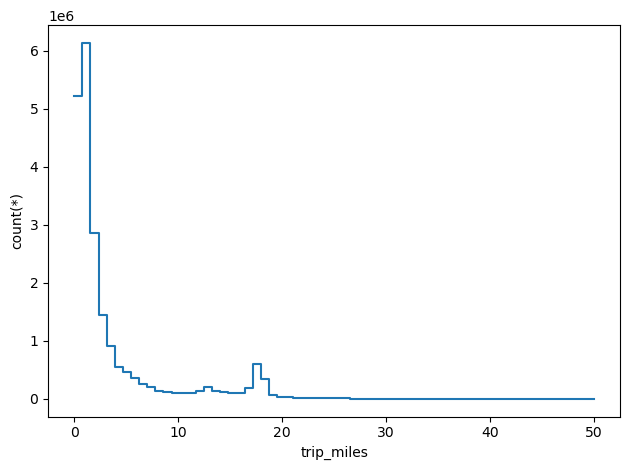

In [30]:
#huge outliers in distance
df.viz.histogram(df.trip_miles, limits=[0,50])

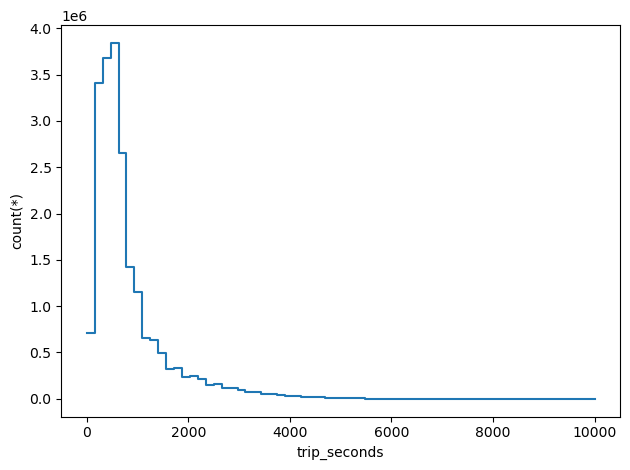

In [31]:
#huge outliers in duration
df.viz.histogram(df.trip_seconds, limits=[0,10000])

In [184]:
#99.9 percent of data lies between 0 miles and 20.4 miles
print("99% confidence miles:", df.limits_percentage('trip_miles', 99))
#99.9 percent of data lies between 128 seconds and 3061 seconds
print("99% confidence duration:", df.limits_percentage('trip_seconds', 99))

99% confidence miles: [6.42631139e-03 2.06979295e+01]
99% confidence duration: [  31.93307163 4313.1268772 ]


In [236]:
#lets take a look at the actual numbers of outliers here
df.select(df.trip_miles > 20.1)
print(len(df.evaluate(df.trip_miles, selection=True)))
df.select(df.trip_seconds < 31.9 and df.trip_seconds > 4313.2)
print(len(df.evaluate(df.trip_seconds, selection=True)))

129627
105377


In [237]:
#fewer than 55.000 rides had been longer than 20 miles therfore we discard those in order to avoid outlier bias
df= df[df['trip_miles'] < 2.06979295e+01]
#Lets take a look at the remaining outliers data regarding the duration
df.select(df.trip_seconds < 31.93307163 and df.trip_seconds > 4313.1268772)
print(len(df.evaluate(df.trip_seconds, selection=True)))

88311


In [238]:
#discard remaining 46000 entries that are outside of the 99% intervall of the data regarding the duration
df= df[df['trip_seconds'] > 31.93307163] 
df= df[df['trip_seconds'] < 4313.1268772 ]

In [239]:
#add weekend column to dataset
df['weekend'] = df['weekday'].apply(lambda x: 1 if x > 4 else 0)

In [240]:
#dropping unneccessary columns and finishing dataframe

df_loc = df.copy()

df.drop(columns = ['trip_start_hour', 'trip_end_hour','pickup_centroid_latitude', 'pickup_centroid_longitude', 'dropoff_centroid_latitude', 'dropoff_centroid_longitude',], inplace=True)
df.head(1)

#,trip_start_timestamp,trip_seconds,trip_miles,month,weekday,hour,day_sin,day_cos,hour_sin,hour_cos,weekend
0,2017-01-01 00:00:00.000000,1800,0,1,6,0,-0.781831,0.62349,0,1,1


In [38]:
#scaling method for variables that need scaling
scaler = StandardScaler()

def scaling(data):
    scaler.fit(data)
    data_scaled = scaler.transform(data)
    df_data_scaled = pd.DataFrame(data_scaled, columns = data.get_column_names())
    return data_scaled, df_data_scaled

In [39]:
#choose number of clusters for k-means

def k_optimal(data, k_max):
    clusters = []
    losses = []
    for k in range(k_max):
        model= MiniBatchKMeans(n_clusters=k+1,random_state=42,init="k-means++") 
        model.fit(data)
        clusters.append(k+1)
        losses.append(model.inertia_)
    plt.plot(clusters, losses)
        #plt.xlim([2,10])
    plt.ylabel("Loss")
    plt.xlabel("Number of clusters")
    plt.show()

### CLUSTERING OF TRIP TYPES FOR HOUR AND DAYTIME

In [52]:
#preparing dataframes for weekend and weekdays data
features = ['trip_seconds']
df_cluster = df.drop(columns = features)
df_cluster_one = df_cluster[df_cluster['weekend'] == 0]
df_cluster_two = df_cluster[df_cluster['weekend'] == 1]

In [54]:
#scaling variables that need scaling for weekdays data
features = ['month', 'weekday', 'hour', 'weekend']

df_cluster_one_scaling = df_cluster_one.drop(columns = features)

cluster_one_scaled, df_cluster_one_scaled =  scaling(df_cluster_one_scaling)

df_cluster_one_scaled = vaex.from_pandas(df_cluster_one_scaled)

In [55]:
#scaling variables that need scaling for weekends data
features = ['month', 'weekday', 'hour', 'weekend']

df_cluster_two_scaling = df_cluster_two.drop(columns = features)

cluster_two_scaled, df_cluster_two_scaled =  scaling(df_cluster_two_scaling)

df_cluster_two_scaled = vaex.from_pandas(df_cluster_two_scaled)

In [56]:
weekdays_df = df_cluster_one_scaled.copy()
weekends_df = df_cluster_two_scaled.copy()

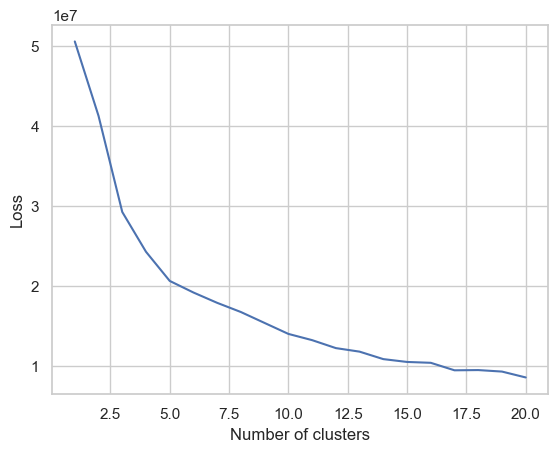

In [147]:
#choose number of clusters for k-means weekdays

k_optimal(weekdays_df, 20)

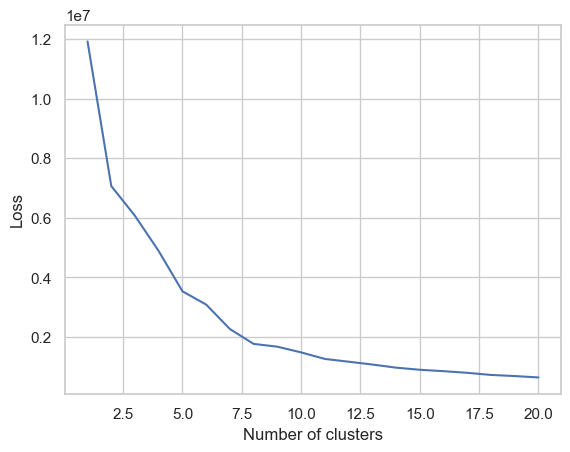

In [164]:
#choose number of clusters for k-means weekends

k_optimal(weekends_df, 20)

In [57]:
#after trying aout several clusters between 3 and 7 we achieved the best results with 5 cluster centers
amount_clusters = 5

In [66]:
# k-mean++ clustering and gmm weekdays

#fit models
means = KMeans(n_clusters=amount_clusters, random_state=42,init="k-means++")
means.fit(weekdays_df)
gmm = GaussianMixture(n_components = amount_clusters, random_state=42)
gmm.fit(weekdays_df)

numbers = ['one', 'two', 'three', 'four', 'five', 'six']
#predict clusters
kmeans_labels = means.predict(weekdays_df)
gmm_labels = gmm.predict(weekdays_df)

weekdays_df["kmeans_cluster"] = kmeans_labels
weekdays_df["kmeans_cluster"] = weekdays_df["kmeans_cluster"].apply(lambda x: numbers[x])

weekdays_df["gmm_cluster"] = gmm_labels
weekdays_df["gmm_cluster"] = weekdays_df["gmm_cluster"].apply(lambda x: numbers[x])

/Users/tim/opt/anaconda3/envs/AAproject/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [67]:
# k-mean++ clustering and gmm weekends

#fit models
means = KMeans(n_clusters=5, random_state=42,init="k-means++")
means.fit(weekends_df)
gmm = GaussianMixture(n_components = 5, random_state=42)
gmm.fit(weekends_df)

numbers = ['one', 'two', 'three', 'four', 'five', 'six']
#predict clusters
kmeans_labels = means.predict(weekends_df)
gmm_labels = gmm.predict(weekends_df)

weekends_df["kmeans_cluster"] = kmeans_labels
weekends_df["kmeans_cluster"] = weekends_df["kmeans_cluster"].apply(lambda x: numbers[x])

weekends_df["gmm_cluster"] = gmm_labels
weekends_df["gmm_cluster"] = weekends_df["gmm_cluster"].apply(lambda x: numbers[x])


/Users/tim/opt/anaconda3/envs/AAproject/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


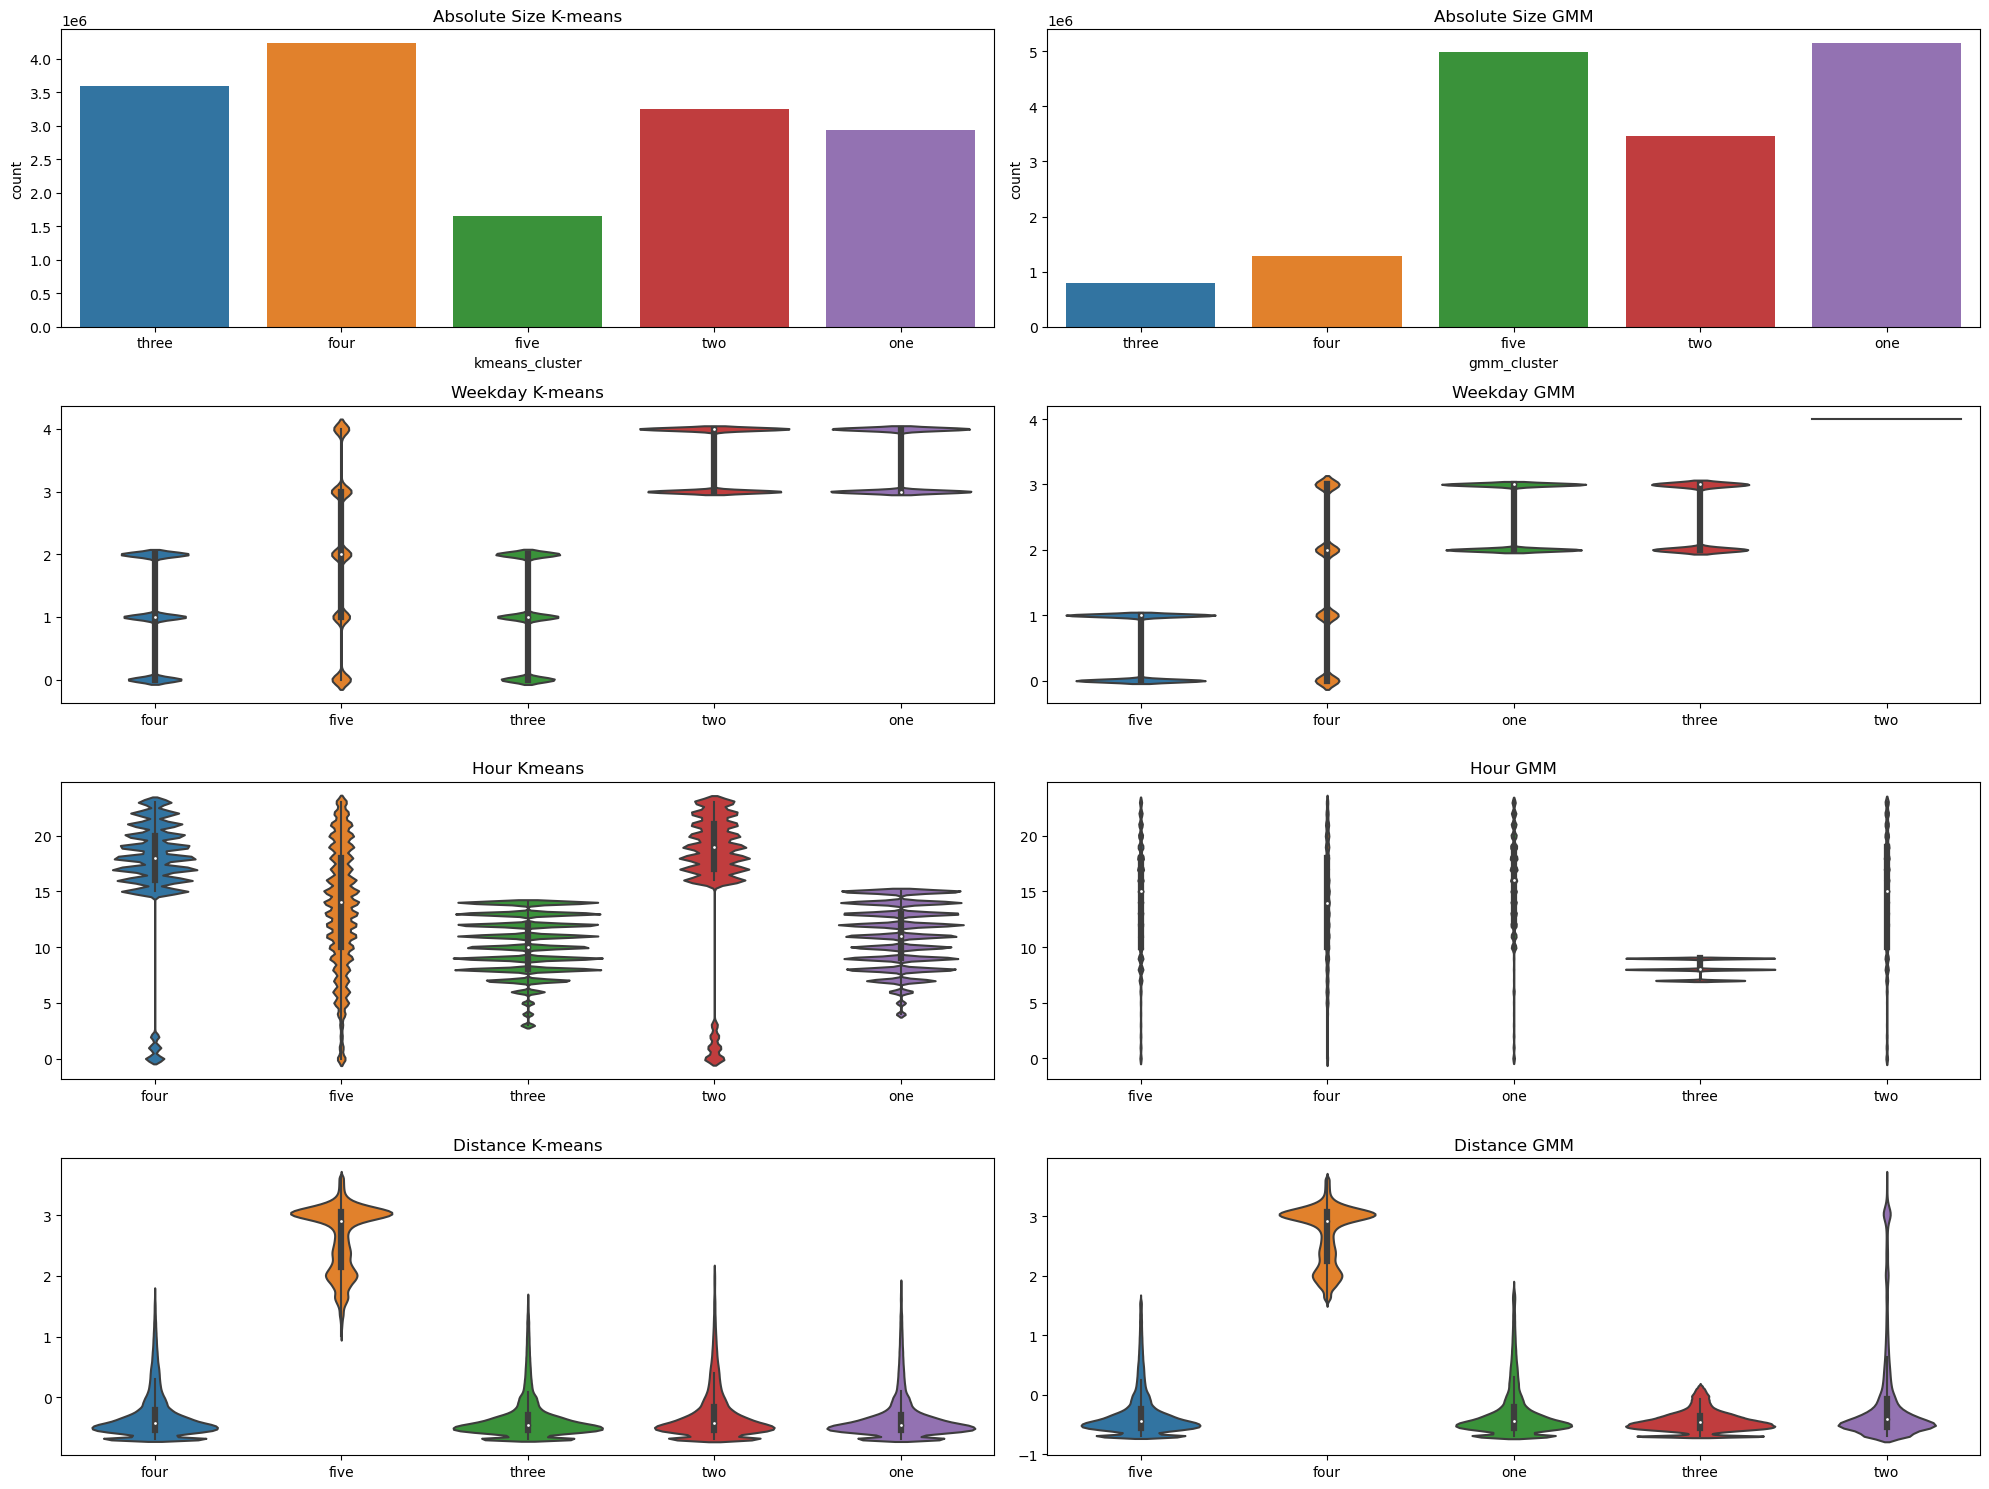

In [68]:
df_dummy = df_cluster_one.drop(columns = ['trip_miles', 'hour_sin','hour_cos', 'day_cos', 'day_sin'])
weekdays_df = weekdays_df.join(df_dummy, allow_duplication=True)

cluster_size_weekdays_kmeans = pd.DataFrame(weekdays_df.groupby(weekdays_df['kmeans_cluster'], agg='count').to_dict())
cluster_size_weekdays_gmm = pd.DataFrame(weekdays_df.groupby(weekdays_df['gmm_cluster'], agg='count').to_dict())

plots, axes = plt.subplots(nrows = 4, ncols = 2, figsize = (20,15))

sns.barplot(ax = axes[0,0], x='kmeans_cluster', y='count', data=cluster_size_weekdays_kmeans)
sns.barplot(ax = axes[0,1], x='gmm_cluster', y='count', data=cluster_size_weekdays_gmm)
sns.violinplot(ax = axes[1, 0], x=weekdays_df['kmeans_cluster'].values, y=weekdays_df.weekday.values)
sns.violinplot(ax = axes[1, 1], x=weekdays_df['gmm_cluster'].values, y=weekdays_df.weekday.values)
sns.violinplot(ax = axes[2, 0], x=weekdays_df['kmeans_cluster'].values, y=weekdays_df.hour.values)
sns.violinplot(ax = axes[2, 1], x=weekdays_df['gmm_cluster'].values, y=weekdays_df.hour.values)
sns.violinplot(ax = axes[3, 0], x=weekdays_df['kmeans_cluster'].values, y=weekdays_df.trip_miles.values)
sns.violinplot(ax = axes[3, 1], x=weekdays_df['gmm_cluster'].values, y=weekdays_df.trip_miles.values)



axes[0, 0].set_title('Absolute Size K-means'), axes[0, 1].set_title('Absolute Size GMM'), axes[1, 0].set_title('Weekday K-means'), axes[1, 1].set_title('Weekday GMM'), axes[2, 0].set_title('Hour Kmeans'), axes[2, 1].set_title('Hour GMM'), axes[3, 0].set_title('Distance K-means'), axes[3, 1].set_title('Distance GMM')

plots.tight_layout()
plt.show()

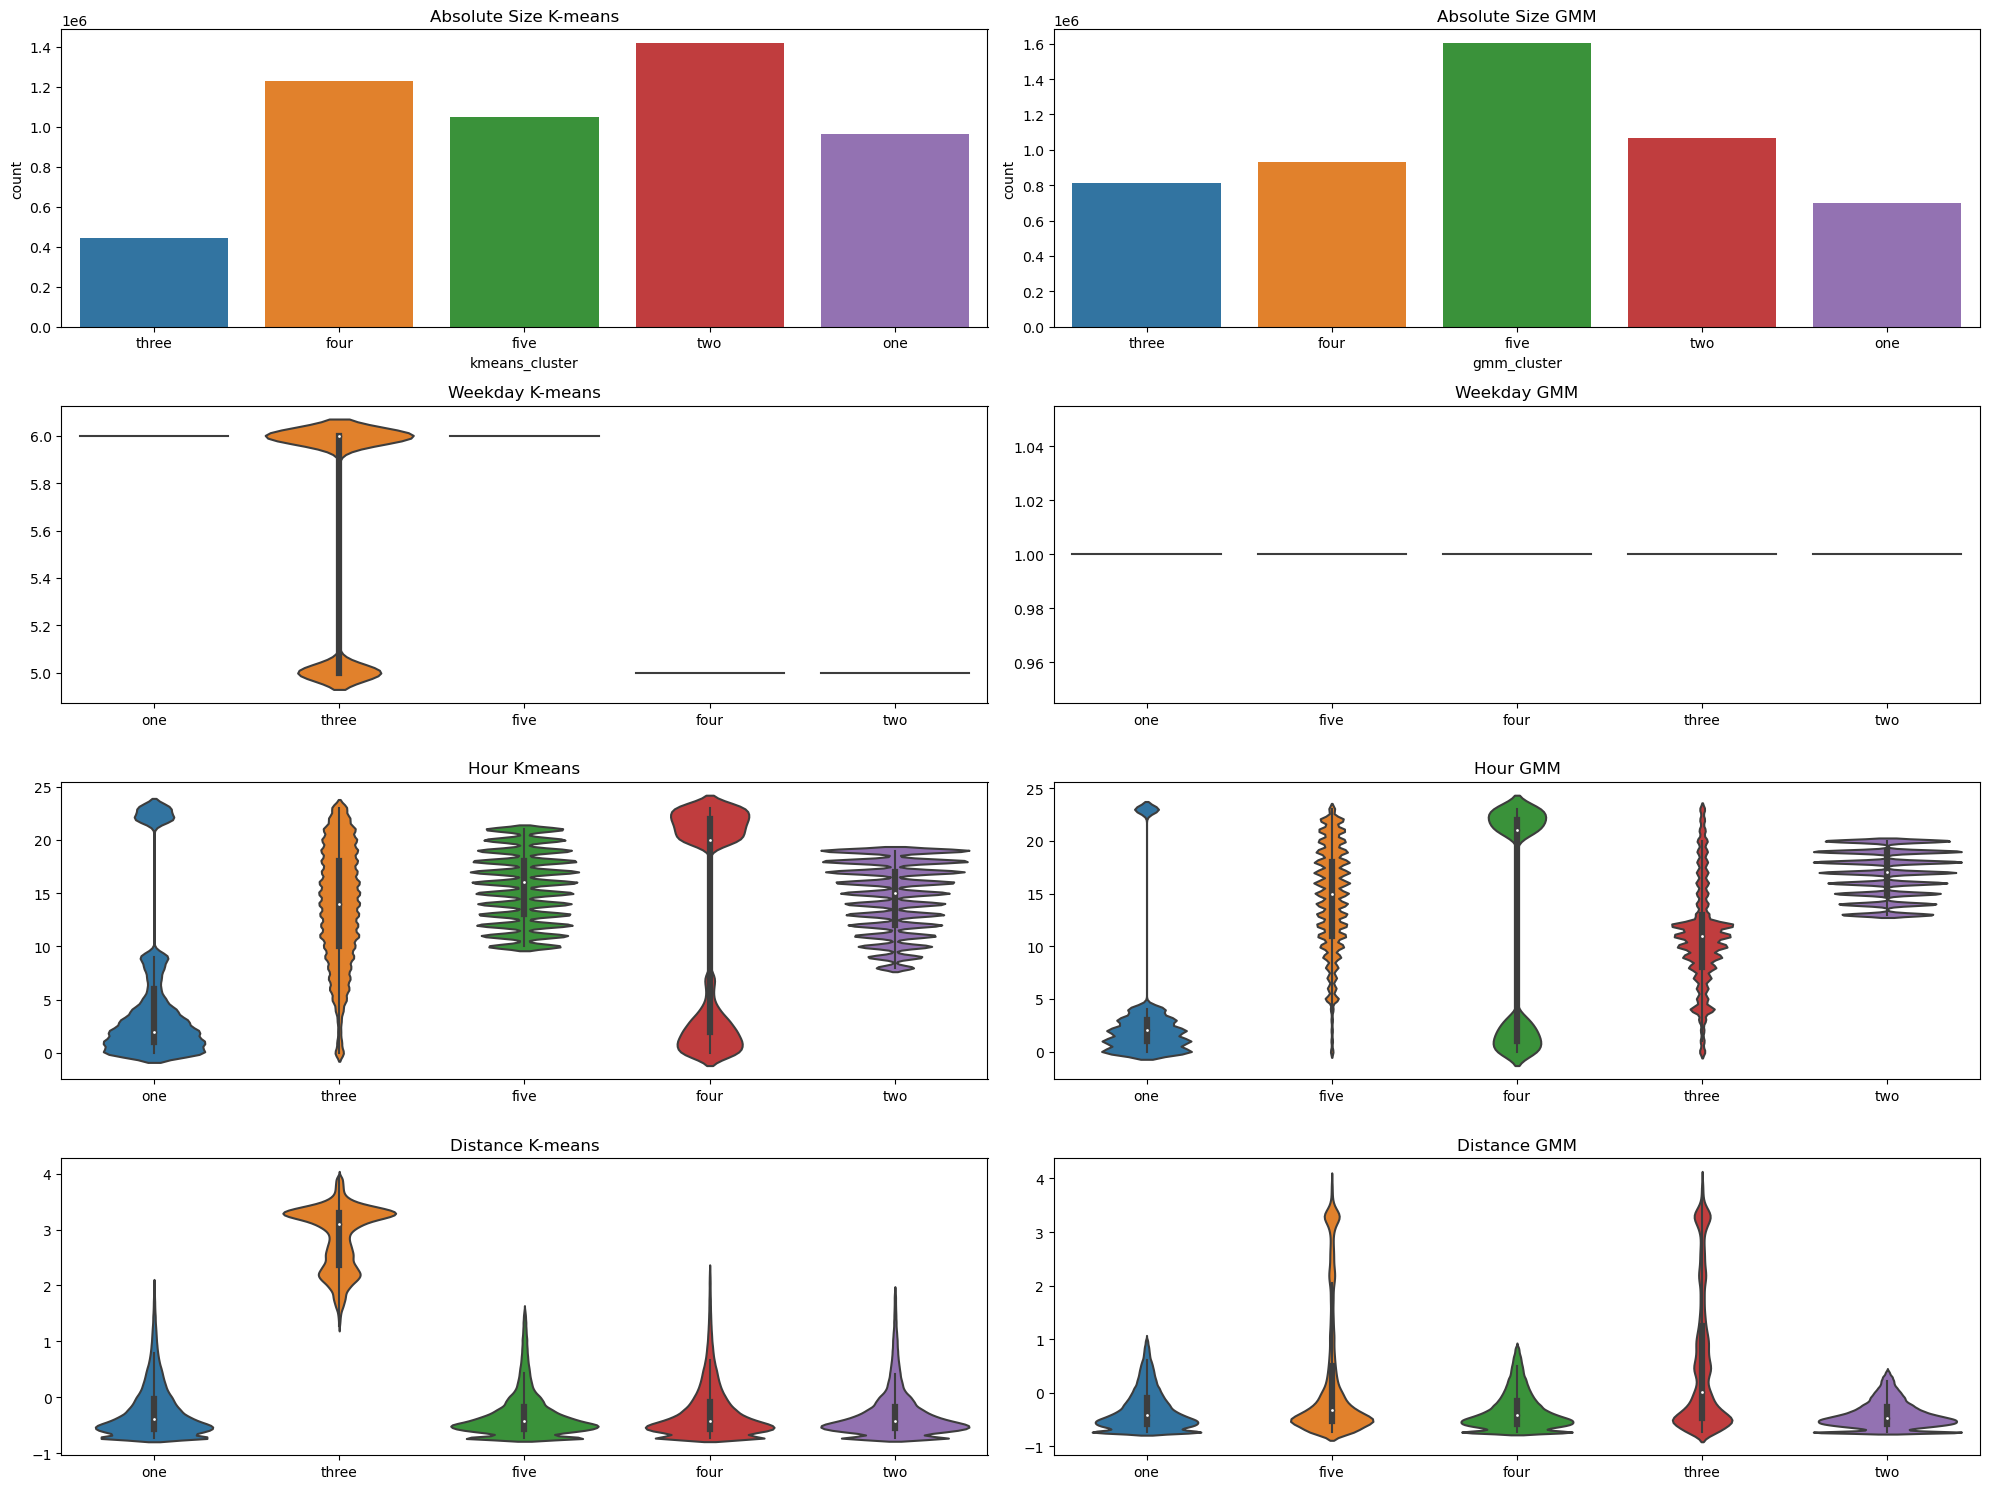

In [69]:
df_dummy = df_cluster_two.drop(columns = ['trip_miles', 'hour_sin','hour_cos', 'day_cos', 'day_sin'])
weekends_df = weekends_df.join(df_dummy, allow_duplication=True)

cluster_size_weekends_kmeans = pd.DataFrame(weekends_df.groupby(weekends_df['kmeans_cluster'], agg='count').to_dict())
cluster_size_weekends_gmm = pd.DataFrame(weekends_df.groupby(weekends_df['gmm_cluster'], agg='count').to_dict())

plots, axes = plt.subplots(nrows = 4, ncols = 2, figsize = (20,15))

sns.barplot(ax = axes[0,0], x='kmeans_cluster', y='count', data=cluster_size_weekends_kmeans)
sns.barplot(ax = axes[0,1], x='gmm_cluster', y='count', data=cluster_size_weekends_gmm)
sns.violinplot(ax = axes[1, 0], x=weekends_df['kmeans_cluster'].values, y=weekends_df.weekday.values)
sns.violinplot(ax = axes[1, 1], x=weekends_df['gmm_cluster'].values, y=weekends_df.weekend.values)
sns.violinplot(ax = axes[2, 0], x=weekends_df['kmeans_cluster'].values, y=weekends_df.hour.values)
sns.violinplot(ax = axes[2, 1], x=weekends_df['gmm_cluster'].values, y=weekends_df.hour.values)
sns.violinplot(ax = axes[3, 0], x=weekends_df['kmeans_cluster'].values, y=weekends_df.trip_miles.values)
sns.violinplot(ax = axes[3, 1], x=weekends_df['gmm_cluster'].values, y=weekends_df.trip_miles.values)



axes[0, 0].set_title('Absolute Size K-means'), axes[0, 1].set_title('Absolute Size GMM'), axes[1, 0].set_title('Weekday K-means'), axes[1, 1].set_title('Weekday GMM'), axes[2, 0].set_title('Hour Kmeans'), axes[2, 1].set_title('Hour GMM'), axes[3, 0].set_title('Distance K-means'), axes[3, 1].set_title('Distance GMM')

plots.tight_layout()
plt.show()

# Clustering trip types for weather

In [441]:
df_wetter = pd.read_csv('./data/weather_data_final.csv')
df_wetter.drop(columns = ['date', 'time', 'dew_point', 'humidity', 'wind_speed', 'wind_gust', 'pressure'], inplace = True)
df_daten = df.copy()

In [442]:
df_wetter['date_time'] = pd.to_datetime(df_wetter['date_time'], format='%Y-%m-%d %H:%M:%S')
df_daten['date_hour_combined'] = df_daten['trip_start_timestamp'].apply(lambda x: f"{x.date()} {x.hour:02d}")
df_daten.drop('trip_start_timestamp', inplace = True)
df_wetter['date_hour_combined'] = df_wetter['date_time'].apply(lambda x: f"{x.date()} {x.hour:02d}")
df_wetter.drop(columns = ['date_time'], inplace = True)
df_wetter['temp'] = df_wetter['temp'].str.slice(stop=-2)
df_wetter['temp'] = df_wetter['temp'].str.replace('\xa0', '')
df_wetter['temp']= df_wetter.temp.astype(int)
df_wetter['precip'] = df_wetter['precip'].str.slice(stop=-3)
df_wetter['precip'] = df_wetter['precip'].str.replace('\xa0', '')
df_wetter['precip']= df_wetter.precip.astype(float)
df_wetter = vaex.from_pandas(df_wetter)
df_combined = df_daten.join(df_wetter, how='inner', on ='date_hour_combined')

In [443]:
df_wth = df_combined.copy()
df_wth.drop(columns = ['date_hour_combined','trip_seconds'], inplace = True)
df_wth.head(1)

#,trip_miles,month,weekday,hour,day_sin,day_cos,hour_sin,hour_cos,weekend,temp,precip,condition
0,0,1,6,0,-0.781831,0.62349,0,1,1,33,0,Partly Cloudy


In [351]:
features = ['month', 'weekday', 'hour', 'weekend', 'temp', 'precip', 'condition']

df_wth_scaling = df_wth.drop(columns = features)

wth_scaled, df_wth_scaled =  scaling(df_wth_scaling)

df_wth_scaled = vaex.from_pandas(df_wth_scaled)

In [447]:
df_weather = df_wth_scaled.copy()
df_dummy = df_wth.drop(columns = ['trip_miles', 'hour_sin','hour_cos', 'day_cos', 'day_sin', 'precip','condition', 'weekend', 'month', 'hour', 'weekday'])
df_weather = df_weather.join(df_dummy, allow_duplication=True)

In [448]:

df_weather.head(1)

#,trip_miles,day_sin,day_cos,hour_sin,hour_cos,temp
0,-0.703848,-1.17758,0.986795,0.373387,1.68213,33


In [ ]:
k_optimal(df_weather, 8)

In [ ]:
amount_clusters = 3

In [ ]:
# k-mean++ clustering and gmm 

#fit models
means = KMeans(n_clusters=amount_clusters, random_state=42,init="k-means++")
means.fit(df_weather)
gmm = GaussianMixture(n_components = amount_clusters, random_state=42)
gmm.fit(df_weather)

numbers = ['one', 'two', 'three', 'four', 'five', 'six']
#predict clusters
kmeans_labels = means.predict(df_weather)
gmm_labels = gmm.predict(df_weather)

df_weather["kmeans_cluster"] = kmeans_labels
df_weather["kmeans_cluster"] = df_weather["kmeans_cluster"].apply(lambda x: numbers[x])

df_weather["gmm_cluster"] = gmm_labels
df_weather["gmm_cluster"] = df_weather["gmm_cluster"].apply(lambda x: numbers[x])

In [ ]:
df_dummy = df_wth.drop(columns = ['trip_miles', 'hour_sin','hour_cos', 'day_cos', 'day_sin', 'temp'])
df_weather = df_weather.join(df_dummy, allow_duplication=True)

cluster_size_weekdays_kmeans = pd.DataFrame(df_weather.groupby(df_weather['kmeans_cluster'], agg='count').to_dict())
cluster_size_weekdays_gmm = pd.DataFrame(df_weather.groupby(df_weather['gmm_cluster'], agg='count').to_dict())

plots, axes = plt.subplots(nrows = 6, ncols = 2, figsize = (20,15))

sns.barplot(ax = axes[0,0], x='kmeans_cluster', y='count', data=cluster_size_weekdays_kmeans)
sns.barplot(ax = axes[0,1], x='gmm_cluster', y='count', data=cluster_size_weekdays_gmm)
sns.violinplot(ax = axes[1, 0], x=df_weather['kmeans_cluster'].values, y=df_weather.weekday.values)
sns.violinplot(ax = axes[1, 1], x=df_weather['gmm_cluster'].values, y=df_weather.weekday.values)
sns.violinplot(ax = axes[2, 0], x=df_weather['kmeans_cluster'].values, y=df_weather.hour.values)
sns.violinplot(ax = axes[2, 1], x=df_weather['gmm_cluster'].values, y=df_weather.hour.values)
sns.violinplot(ax = axes[3, 0], x=df_weather['kmeans_cluster'].values, y=df_weather.trip_miles.values)
sns.violinplot(ax = axes[3, 1], x=df_weather['gmm_cluster'].values, y=df_weather.trip_miles.values)
sns.violinplot(ax = axes[4, 0], x=df_weather['kmeans_cluster'].values, y=df_weather.temp.values)
sns.violinplot(ax = axes[4, 1], x=df_weather['gmm_cluster'].values, y=df_weather.temp.values)
#sns.violinplot(ax = axes[5, 0], x=df_weather['kmeans_cluster'].values, y=df_weather.precip.values)
#sns.violinplot(ax = axes[5, 1], x=df_weather['gmm_cluster'].values, y=df_weather.precip.values)


axes[0, 0].set_title('Absolute Size K-means'), axes[0, 1].set_title('Absolute Size GMM'), axes[1, 0].set_title('Weekday K-means'), axes[1, 1].set_title('Weekday GMM'), axes[2, 0].set_title('Hour Kmeans'), axes[2, 1].set_title('Hour GMM'), axes[3, 0].set_title('Distance K-means'), axes[3, 1].set_title('Distance GMM')

plots.tight_layout()
plt.show()

In [ ]:
plots, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20,15))

sns.violinplot(ax = axes[1, 0], x=df_weather['kmeans_cluster'].values, y=df_weather.temp.values)
sns.violinplot(ax = axes[1, 1], x=df_weather['gmm_cluster'].values, y=df_weather.temp.values)
sns.violinplot(ax = axes[2, 0], x=df_weather['kmeans_cluster'].values, y=df_weather.precip.values)
sns.violinplot(ax = axes[2, 1], x=df_weather['gmm_cluster'].values, y=df_weather.precip.values)

plots.tight_layout()
plt.show()

In [ ]:
one = df_weather[df_weather['kmeans_cluster'] == 'one']['temp']
two = df_weather[df_weather['kmeans_cluster'] == 'two']
three = df_weather[df_weather['kmeans_cluster'] == 'three']
four = df_weather[df_weather['kmeans_cluster'] == 'four']
five = df_weather.[df_weather['kmeans_cluster'] == 'five']

one['average'] = one.mean(numeric_only = True, axis = 1)
two['average'] = two.mean(numeric_only = True, axis = 1)
three['average'] = three.mean(numeric_only = True, axis = 1)
four['average'] = four.mean(numeric_only = True, axis = 1)
five['average'] = five.mean(numeric_only = True, axis = 1)


In [392]:
one = df_weather[df_weather['kmeans_cluster'] == 'one']

## Clustering Locations

In [190]:
df_location = df_loc.copy()

In [191]:
def convert_to_h3(lat,long):
    return h3.geo_to_h3(lat, long, 8)

In [192]:
#adding hexagon information for clustering
df_location['pickup_hex'] = df_location.apply(convert_to_h3, [df_location['pickup_centroid_latitude'], df_location['pickup_centroid_longitude']])
df_location['dropoff_hex'] = df_location.apply(convert_to_h3, [df_location['dropoff_centroid_latitude'], df_location['dropoff_centroid_longitude']])

# Lets first look on the start locations

In [128]:
#preparing dataframe and cound the number of occurences at every pickup cencus tract per each hour of a day
df_location_start = df_location[['pickup_hex', 'trip_start_hour', 'weekday']]
df_location_start = df_location_start[df_location_start['weekday'] < 5]
df_location_start.drop(columns = ['weekday'], inplace = True)
df_location_start_pd = pd.DataFrame(df_location_start.to_dict())
df_location_start_pd.rename(columns = {0: 'pickup_hex', 1: 'trip_start_hour'}, inplace = True)
df_location_start_pd.loc[:,"hour"] = df_location_start_pd['trip_start_hour'].apply(lambda x: np.trunc(x))
df_location_start_pd = df_location_start_pd.groupby(['trip_start_hour', 'pickup_hex']).size().unstack()
df_location_start_pd = df_location_start_pd.fillna(0) #fill NaN entrys with 0
df_location_start_pd


pickup_hex,8826641915fffff,8826641961fffff,8826641b23fffff,882664520bfffff,8826645215fffff,8826645219fffff,8826645253fffff,88266452c9fffff,88266452dbfffff,8826645613fffff,...,882759340bfffff,8827593433fffff,88275934edfffff,8827593697fffff,8827593699fffff,882759369bfffff,88275936b1fffff,88275936bbfffff,88275936d3fffff,88275936d5fffff
trip_start_hour,,,,,,,,,,,,,,,,,,,,,
0,0.0,13.0,1.0,4392.0,15.0,4249.0,0.0,11.0,13.0,1.0,...,0.0,11152.0,13307.0,0.0,261.0,0.0,1.0,0.0,0.0,10.0
1,1.0,9.0,2.0,3518.0,13.0,1898.0,0.0,11.0,11.0,0.0,...,0.0,6044.0,4833.0,0.0,158.0,1.0,0.0,0.0,0.0,13.0
2,0.0,8.0,0.0,1871.0,6.0,527.0,0.0,6.0,10.0,0.0,...,0.0,2575.0,1327.0,0.0,112.0,0.0,0.0,0.0,0.0,7.0
3,1.0,6.0,0.0,611.0,43.0,85.0,0.0,7.0,42.0,2.0,...,0.0,1146.0,391.0,0.0,129.0,0.0,0.0,0.0,0.0,5.0
4,0.0,9.0,2.0,331.0,50.0,19.0,0.0,11.0,69.0,5.0,...,2.0,1748.0,663.0,0.0,192.0,0.0,0.0,0.0,0.0,13.0
5,9.0,26.0,35.0,372.0,31.0,32.0,0.0,16.0,33.0,18.0,...,0.0,3916.0,2345.0,0.0,268.0,0.0,0.0,0.0,0.0,31.0
6,60.0,32.0,25.0,764.0,29.0,817.0,0.0,19.0,40.0,5.0,...,2.0,4111.0,5602.0,0.0,467.0,4.0,3.0,0.0,0.0,233.0
7,25.0,50.0,2.0,1501.0,34.0,5384.0,1.0,34.0,249.0,7.0,...,2.0,3704.0,8878.0,0.0,604.0,0.0,6.0,0.0,0.0,27.0
8,9.0,116.0,8.0,1886.0,40.0,9218.0,0.0,26.0,84.0,9.0,...,0.0,4675.0,19940.0,0.0,470.0,0.0,3.0,0.0,0.0,30.0


In [129]:
#prepare vaex dataframe from pandas dataframe
df_location_start = vaex.from_pandas(df_location_start_pd)
df_location_start

#scaling data
location_start_scaled, df_location_start_scaled = scaling(df_location_start)

#transpose data to have more convenient visualization
location_start_scaled_trans = location_start_scaled.transpose()
df_location_start_scaled_trans = df_location_start_scaled.transpose()
df_k_optimal = df_location_start_scaled_trans.copy()

In [ ]:
#choose number of cluster centers 

k_optimal(df_k_optimal, 10)

In [134]:
number_components = 3

In [169]:
#apply k-means++ and gmm
df_clustering = df_location_start_scaled_trans.copy()
means = KMeans(n_clusters=number_components, random_state=42,init="k-means++")
means.fit(df_clustering)
gmm = GaussianMixture(n_components = number_components, random_state = 42)
gmm.fit(df_clustering)

numbers_kmeans = ['morning rides', 'midday/afternoon rides', 'latenight rides', 'four', 'five', 'six']
numbers_gmm = ['morning rides', 'midday/afternoon rides', 'latenight rides', 'four', 'five', 'six']

#add cluster lables to the dataset
df_cluster_kmeans = means.predict(location_start_scaled_trans)
df_cluster_gmm = gmm.predict(location_start_scaled_trans)

df_clustering["kmeans_cluster"] = df_cluster_kmeans
df_clustering["kmeans_cluster"] = df_clustering["kmeans_cluster"].apply(lambda x: numbers_kmeans[x])
df_clustering["gmm_cluster"] = df_cluster_gmm
df_clustering["gmm_cluster"] = df_clustering["gmm_cluster"].apply(lambda x: numbers_gmm[x])



/Users/tim/opt/anaconda3/envs/AAproject/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [170]:
cluster_sizes_kmeans = df_clustering.groupby(['kmeans_cluster'])['kmeans_cluster'].agg('count')
cluster_sizes_gmm = df_clustering.groupby(['gmm_cluster'])['gmm_cluster'].agg('count')
print(cluster_sizes_kmeans)
print(cluster_sizes_gmm)

kmeans_cluster
latenight rides            75
midday/afternoon rides    122
morning rides             114
Name: kmeans_cluster, dtype: int64
gmm_cluster
latenight rides           118
midday/afternoon rides    115
morning rides              78
Name: gmm_cluster, dtype: int64


In [171]:
#sort stations into respective cluster dataframes
df_stations_one = df_clustering.loc[df_clustering['kmeans_cluster'] == 'morning rides']
df_stations_two = df_clustering.loc[df_clustering['kmeans_cluster'] == 'latenight rides']
df_stations_three = df_clustering.loc[df_clustering['kmeans_cluster'] == 'midday/afternoon rides']
#df_stations_four = df_clustering.loc[df_clustering['kmeans_cluster'] == 'four']

#gmm
df_stations_one_gmm = df_clustering.loc[df_clustering['gmm_cluster'] == 'morning rides']
df_stations_two_gmm = df_clustering.loc[df_clustering['gmm_cluster'] == 'midday/afternoon rides']
df_stations_three_gmm = df_clustering.loc[df_clustering['gmm_cluster'] == 'latenight rides']
#df_stations_four_gmm = df_clustering.loc[df_clustering['gmm_cluster'] == 'four']

#drop the cluster column as its not needed anymore
df_stations_one = df_stations_one.drop(['kmeans_cluster','gmm_cluster'], axis = 1)
df_stations_two = df_stations_two.drop(['kmeans_cluster','gmm_cluster'], axis = 1)
df_stations_three = df_stations_three.drop(['kmeans_cluster','gmm_cluster'], axis = 1)
#df_stations_four = df_stations_four.drop(['kmeans_cluster','gmm_cluster'], axis = 1)

#gmm
df_stations_one_gmm = df_stations_one_gmm.drop(['gmm_cluster','kmeans_cluster'], axis = 1)
df_stations_two_gmm = df_stations_two_gmm.drop(['gmm_cluster','kmeans_cluster'], axis = 1)
df_stations_three_gmm = df_stations_three_gmm.drop(['gmm_cluster','kmeans_cluster'], axis = 1)
#df_stations_four_gmm = df_stations_four_gmm.drop(['gmm_cluster','kmeans_cluster'], axis = 1)

#transpose and calculate average over every hour of the day 
df_stations_one = df_stations_one.transpose()
df_stations_two = df_stations_two.transpose()
df_stations_three = df_stations_three.transpose()
#df_stations_four = df_stations_four.transpose()

df_stations_one['average'] = df_stations_one.mean(numeric_only = True, axis = 1)
df_stations_two['average'] = df_stations_two.mean(numeric_only = True, axis = 1)
df_stations_three['average'] = df_stations_three.mean(numeric_only = True, axis = 1)
#df_stations_four['average'] = df_stations_four.mean(numeric_only = True, axis = 1)

#gmm
df_stations_one_gmm = df_stations_one_gmm.transpose()
df_stations_two_gmm = df_stations_two_gmm.transpose()
df_stations_three_gmm = df_stations_three_gmm.transpose()
#df_stations_four_gmm = df_stations_four_gmm.transpose()

df_stations_one_gmm['average'] = df_stations_one_gmm.mean(numeric_only = True, axis = 1)
df_stations_two_gmm['average'] = df_stations_two_gmm.mean(numeric_only = True, axis = 1)
df_stations_three_gmm['average'] = df_stations_three_gmm.mean(numeric_only = True, axis = 1)
#df_stations_four_gmm['average'] = df_stations_four_gmm.mean(numeric_only = True, axis = 1)

(None,
 Text(0.5, 1.0, 'Cluster 3: midday/afternoon rides'),
 Text(150.09722222222223, 0.5, 'Trips'),
 Text(0.5, 47.7222222222222, 'Start Hour'))

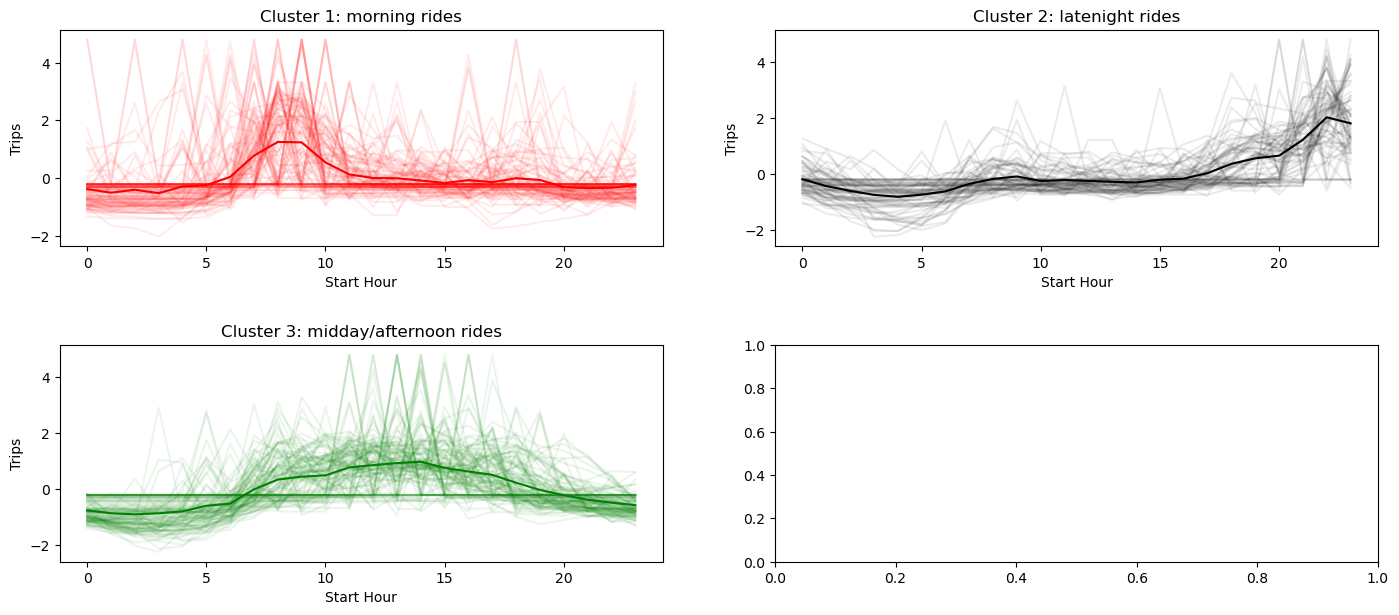

In [172]:
#plot the results kmeans
fig, ax = plt.subplots(nrows = 2, ncols = 2,figsize=(15,7))
fig.tight_layout(pad = 5)

df_stations_one.plot(ax=ax[0,0],color='red', alpha=0.08)
df_stations_one["average"].plot(ax=ax[0,0],color='red', alpha=1)
ax[0,0].get_legend().remove(), ax[0,0].set_title('Cluster 1: morning rides'), ax[0,0].set_ylabel('Trips'), ax[0,0].set_xlabel('Start Hour')

df_stations_two.plot(ax=ax[0,1],color='black', alpha=0.08)
df_stations_two["average"].plot(ax=ax[0,1],color='black', alpha=1)
ax[0,1].get_legend().remove(), ax[0,1].set_title('Cluster 2: latenight rides'), ax[0,1].set_ylabel('Trips'), ax[0,1].set_xlabel('Start Hour')

df_stations_three.plot(ax=ax[1,0],color='green', alpha=0.08)
df_stations_three["average"].plot(ax=ax[1,0],color='green', alpha=1)
ax[1,0].get_legend().remove(), ax[1,0].set_title('Cluster 3: midday/afternoon rides'), ax[1,0].set_ylabel('Trips'), ax[1,0].set_xlabel('Start Hour')

#df_stations_four.plot(ax=ax[1,1],color='blue', alpha=0.08)
#df_stations_four["average"].plot(ax=ax[1,1],color='blue', alpha=1)
#ax[1,1].get_legend().remove(), ax[1,1].set_title('Cluster 3: Work/University\nArea'), ax[1,1].set_ylabel('Trips'), ax[1,1].set_xlabel('Start Hour')

(None,
 Text(0.5, 1.0, 'Cluster 3: latenight rides'),
 Text(150.09722222222223, 0.5, 'Trips'),
 Text(0.5, 47.7222222222222, 'Start Hour'))

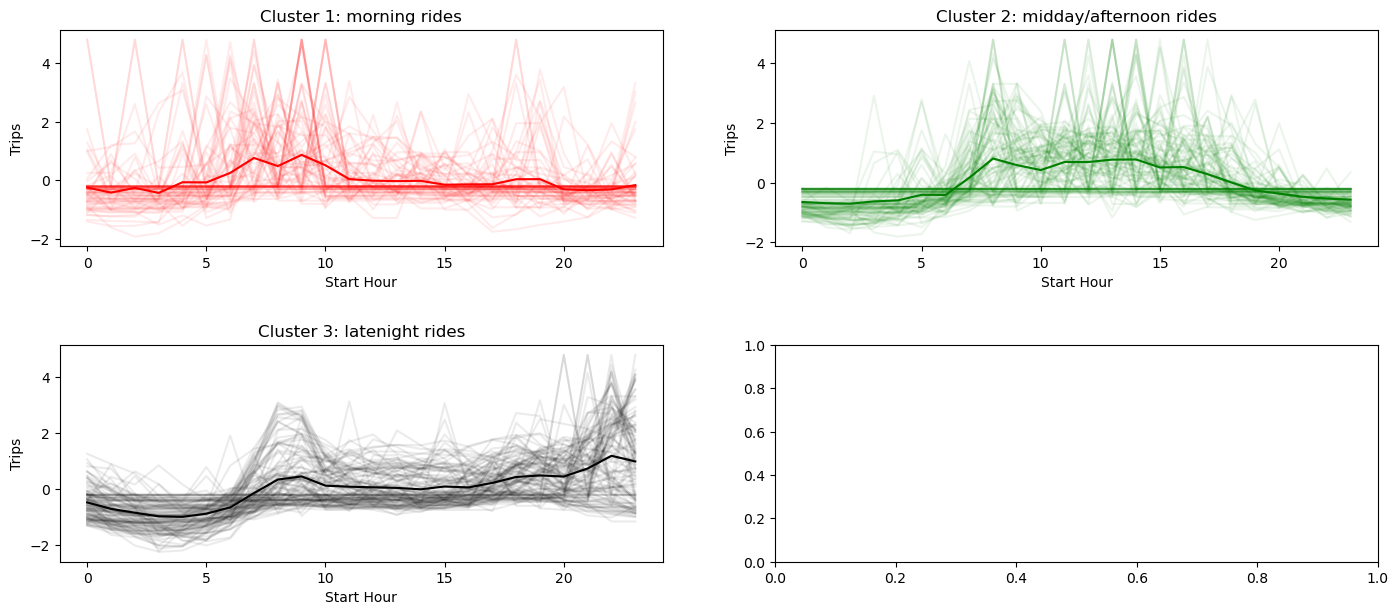

In [174]:
#plot the results gmm
fig, ax = plt.subplots(nrows = 2, ncols = 2,figsize=(15,7))
fig.tight_layout(pad = 5)

df_stations_one_gmm.plot(ax=ax[0,0],color='red', alpha=0.08)
df_stations_one_gmm["average"].plot(ax=ax[0,0],color='red', alpha=1)
ax[0,0].get_legend().remove(), ax[0,0].set_title('Cluster 1: morning rides'), ax[0,0].set_ylabel('Trips'), ax[0,0].set_xlabel('Start Hour')

df_stations_two_gmm.plot(ax=ax[0,1],color='green', alpha=0.08)
df_stations_two_gmm["average"].plot(ax=ax[0,1],color='green', alpha=1)
ax[0,1].get_legend().remove(), ax[0,1].set_title('Cluster 2: midday/afternoon rides'), ax[0,1].set_ylabel('Trips'), ax[0,1].set_xlabel('Start Hour')

df_stations_three_gmm.plot(ax=ax[1,0],color='black', alpha=0.08)
df_stations_three_gmm["average"].plot(ax=ax[1,0],color='black', alpha=1)
ax[1,0].get_legend().remove(), ax[1,0].set_title('Cluster 3: latenight rides'), ax[1,0].set_ylabel('Trips'), ax[1,0].set_xlabel('Start Hour')

#df_stations_four_gmm.plot(ax=ax[1,1],color='blue', alpha=0.08)
#df_stations_four_gmm["average"].plot(ax=ax[1,1],color='blue', alpha=1)
#ax[1,1].get_legend().remove(), ax[1,1].set_title('Cluster 3: Work/University\nArea'), ax[1,1].set_ylabel('Trips'), ax[1,1].set_xlabel('Start Hour')

In [175]:
# spatial visualization preperation

# retrieve hexagon ID thorugh row index for each hexagon
df_clustering['agg_hex_id'] = df_clustering.index

# Add geometries (POLYGON) to dataframe by querying the h3 hexagon boundaries 
df_clustering['geometry'] = df_clustering['agg_hex_id'].apply(lambda id: Polygon(h3.h3_to_geo_boundary(id, geo_json=True)))

# create geodataframe for visualization  by extracting geometry of each hexagon and corresponding cluster assginments
df_viz_kmeans = geopandas.GeoDataFrame(df_clustering[['geometry', 'kmeans_cluster']], crs='EPSG:4326')
df_viz_gmm = geopandas.GeoDataFrame(df_clustering[['geometry', 'gmm_cluster']], crs='EPSG:4326')

In [176]:
df_viz_kmeans.head(3)

,geometry,kmeans_cluster
8826641915fffff,"POLYGON ((-87.54296 41.66657, -87.54898 41.664...",morning rides
8826641961fffff,"POLYGON ((-87.57319 41.69756, -87.57921 41.695...",midday/afternoon rides
8826641b23fffff,"POLYGON ((-87.53039 41.71477, -87.53641 41.712...",morning rides


In [177]:

df_viz_kmeans.explore(column = 'kmeans_cluster', cmap = ['black', 'green', 'red'])

In [178]:
df_viz_gmm.explore(column = 'gmm_cluster', cmap = ['black', 'green', 'red'])

# Now lets look at the End locations

In [193]:
df_location_end = df_location[['dropoff_hex', 'trip_end_hour', 'weekday']]
df_location_end = df_location_end[df_location_end['weekday'] < 5]
df_location_end.drop(columns = ['weekday'], inplace = True)
df_location_end_pd = pd.DataFrame(df_location_end.to_dict())
df_location_end_pd.rename(columns = {0: 'dropoff_hex', 1: 'trip_end_hour'}, inplace = True)
df_location_end_pd.loc[:,"hour"] = df_location_end_pd['trip_end_hour'].apply(lambda x: np.trunc(x))
df_location_end_pd = df_location_end_pd.groupby(['trip_end_hour', 'dropoff_hex']).size().unstack()
df_location_end_pd = df_location_end_pd.fillna(0) #fill NaN entrys with 0
df_location_end_pd

dropoff_hex,8826641915fffff,8826641961fffff,8826641963fffff,8826641b23fffff,8826645205fffff,882664520bfffff,8826645215fffff,8826645219fffff,8826645231fffff,882664523bfffff,...,8827593697fffff,8827593699fffff,882759369bfffff,882759369dfffff,88275936b1fffff,88275936b7fffff,88275936bbfffff,88275936cbfffff,88275936d3fffff,88275936d5fffff
trip_end_hour,,,,,,,,,,,,,,,,,,,,,
0,3.0,37.0,0.0,30.0,0.0,563.0,188.0,78.0,0.0,0.0,...,2.0,1009.0,1.0,0.0,47.0,0.0,8.0,0.0,0.0,217.0
1,2.0,30.0,0.0,8.0,0.0,414.0,138.0,25.0,0.0,0.0,...,0.0,681.0,3.0,0.0,7.0,0.0,0.0,0.0,0.0,121.0
2,1.0,84.0,0.0,2.0,0.0,353.0,82.0,10.0,0.0,0.0,...,0.0,403.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,63.0
3,2.0,30.0,0.0,1.0,0.0,892.0,52.0,155.0,0.0,0.0,...,3.0,240.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0
4,2.0,20.0,0.0,5.0,0.0,3535.0,44.0,1755.0,0.0,0.0,...,0.0,251.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.0
5,0.0,17.0,0.0,4.0,0.0,4805.0,52.0,4167.0,0.0,0.0,...,0.0,307.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,28.0
6,4.0,21.0,0.0,4.0,0.0,4329.0,65.0,6920.0,0.0,0.0,...,0.0,411.0,2.0,0.0,10.0,0.0,1.0,0.0,0.0,30.0
7,3.0,34.0,0.0,8.0,0.0,3240.0,72.0,9005.0,0.0,0.0,...,0.0,600.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,49.0
8,3.0,74.0,0.0,8.0,0.0,1685.0,82.0,7868.0,0.0,0.0,...,0.0,796.0,0.0,1.0,241.0,0.0,0.0,0.0,0.0,56.0


In [194]:
df_location_end = vaex.from_pandas(df_location_end_pd)
df_location_end

#scaling data
location_end_scaled, df_location_end_scaled = scaling(df_location_end)

#transpose data to have more convenient visualization
location_end_scaled_trans = location_end_scaled.transpose()
df_location_end_scaled_trans = df_location_end_scaled.transpose()
df_k_optimal = df_location_end_scaled_trans.copy()

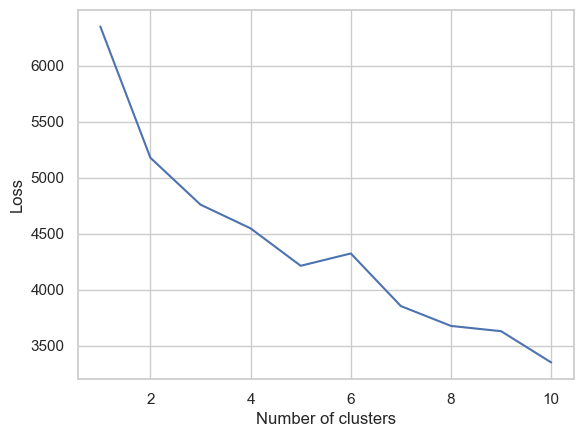

In [673]:
#choose number of cluster centers for k-means++

k_optimal(df_k_optimal, 10)

In [ ]:
#even though 4 and 5 seem more fitting, they yieled no better results than 3 cluster centers, therefore we used 3

In [206]:
#apply k-means++ and gmm
df_clustering_end = df_location_end_scaled_trans.copy()
means = KMeans(n_clusters=3, random_state=42,init="k-means++")
means.fit(df_clustering_end)
gmm = GaussianMixture(n_components = 3, random_state=42)
gmm.fit(df_clustering_end)

numbers_kmeans = ['daytime rides', 'afternoon rides', 'latenight rides', 'latenight rides', 'five', 'six']
numbers_gmm = ['daytime rides', 'afternoon rides', 'latenight rides', 'work rides', 'five', 'six']

#add cluster lables to the dataset
df_cluster_kmeans = means.predict(location_end_scaled_trans)
df_cluster_gmm = gmm.predict(location_end_scaled_trans)

df_clustering_end["kmeans_cluster"] = df_cluster_kmeans
df_clustering_end["kmeans_cluster"] = df_clustering_end["kmeans_cluster"].apply(lambda x: numbers_kmeans[x])
df_clustering_end["gmm_cluster"] = df_cluster_gmm
df_clustering_end["gmm_cluster"] = df_clustering_end["gmm_cluster"].apply(lambda x: numbers_gmm[x])



/Users/tim/opt/anaconda3/envs/AAproject/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [207]:
cluster_sizes_kmeans_end = df_clustering_end.groupby(['kmeans_cluster'])['kmeans_cluster'].agg('count')
cluster_sizes_gmm_end = df_clustering_end.groupby(['gmm_cluster'])['gmm_cluster'].agg('count')
print(cluster_sizes_kmeans_end)
print(cluster_sizes_gmm_end)

kmeans_cluster
afternoon rides    115
daytime rides      139
latenight rides    169
Name: kmeans_cluster, dtype: int64
gmm_cluster
afternoon rides    123
daytime rides      154
latenight rides    146
Name: gmm_cluster, dtype: int64


In [209]:
#sort stations into respective cluster dataframes
df_stations_one = df_clustering_end.loc[df_clustering_end['kmeans_cluster'] == 'daytime rides']
df_stations_two = df_clustering_end.loc[df_clustering_end['kmeans_cluster'] == 'afternoon rides']
df_stations_three = df_clustering_end.loc[df_clustering_end['kmeans_cluster'] == 'latenight rides']
#df_stations_four = df_clustering_end.loc[df_clustering_end['kmeans_cluster'] == 'latenight rides']


#gmm
df_stations_one_gmm = df_clustering_end.loc[df_clustering_end['gmm_cluster'] == 'daytime rides']
df_stations_two_gmm = df_clustering_end.loc[df_clustering_end['gmm_cluster'] == 'afternoon rides']
df_stations_three_gmm = df_clustering_end.loc[df_clustering_end['gmm_cluster'] == 'latenight rides']
#df_stations_four_gmm = df_clustering_end.loc[df_clustering_end['gmm_cluster'] == 'work rides']

#drop the cluster column as its not needed anymore
df_stations_one = df_stations_one.drop(['kmeans_cluster','gmm_cluster'], axis = 1)
df_stations_two = df_stations_two.drop(['kmeans_cluster','gmm_cluster'], axis = 1)
df_stations_three = df_stations_three.drop(['kmeans_cluster','gmm_cluster'], axis = 1)
#df_stations_four = df_stations_four.drop(['kmeans_cluster','gmm_cluster'], axis = 1)


#gmm
df_stations_one_gmm = df_stations_one_gmm.drop(['gmm_cluster','kmeans_cluster'], axis = 1)
df_stations_two_gmm = df_stations_two_gmm.drop(['gmm_cluster','kmeans_cluster'], axis = 1)
df_stations_three_gmm = df_stations_three_gmm.drop(['gmm_cluster','kmeans_cluster'], axis = 1)
#df_stations_four_gmm = df_stations_four_gmm.drop(['gmm_cluster','kmeans_cluster'], axis = 1)

#transpose and calculate average over every hour of the day 
df_stations_one = df_stations_one.transpose()
df_stations_two = df_stations_two.transpose()
df_stations_three = df_stations_three.transpose()
#df_stations_four = df_stations_four.transpose()

df_stations_one['average'] = df_stations_one.mean(numeric_only = True, axis = 1)
df_stations_two['average'] = df_stations_two.mean(numeric_only = True, axis = 1)
df_stations_three['average'] = df_stations_three.mean(numeric_only = True, axis = 1)
#df_stations_four['average'] = df_stations_four.mean(numeric_only = True, axis = 1)


#gmm
df_stations_one_gmm = df_stations_one_gmm.transpose()
df_stations_two_gmm = df_stations_two_gmm.transpose()
df_stations_three_gmm = df_stations_three_gmm.transpose()
#df_stations_four_gmm = df_stations_four_gmm.transpose()


df_stations_one_gmm['average'] = df_stations_one_gmm.mean(numeric_only = True, axis = 1)
df_stations_two_gmm['average'] = df_stations_two_gmm.mean(numeric_only = True, axis = 1)
df_stations_three_gmm['average'] = df_stations_three_gmm.mean(numeric_only = True, axis = 1)
#df_stations_four_gmm['average'] = df_stations_four_gmm.mean(numeric_only = True, axis = 1)


(None,
 Text(0.5, 1.0, 'Cluster 3: latenight rides'),
 Text(150.09722222222223, 0.5, 'Trips'),
 Text(0.5, 47.7222222222222, 'Start Hour'))

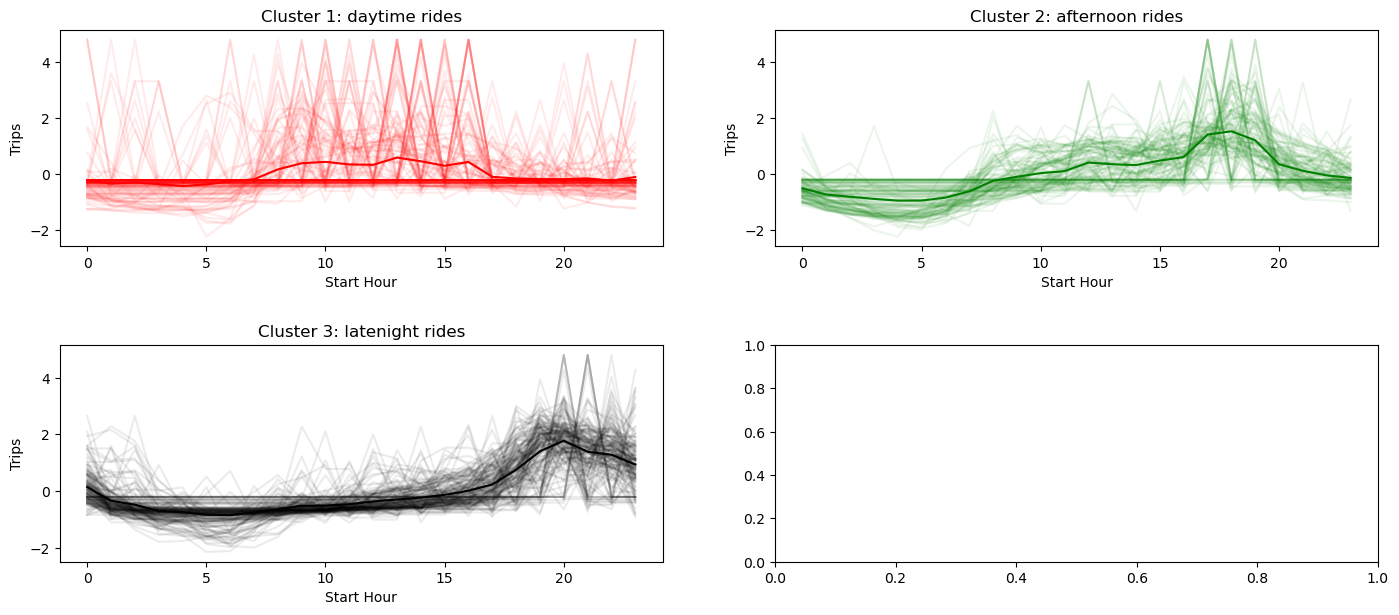

In [211]:
#plot the results kmeans
fig, ax = plt.subplots(nrows = 2, ncols = 2,figsize=(15,7))
fig.tight_layout(pad = 5)

df_stations_one.plot(ax=ax[0,0],color='red', alpha=0.08)
df_stations_one["average"].plot(ax=ax[0,0],color='red', alpha=1)
ax[0,0].get_legend().remove(), ax[0,0].set_title('Cluster 1: daytime rides'), ax[0,0].set_ylabel('Trips'), ax[0,0].set_xlabel('Start Hour')

df_stations_two.plot(ax=ax[0,1],color='green', alpha=0.08)
df_stations_two["average"].plot(ax=ax[0,1],color='green', alpha=1)
ax[0,1].get_legend().remove(), ax[0,1].set_title('Cluster 2: afternoon rides'), ax[0,1].set_ylabel('Trips'), ax[0,1].set_xlabel('Start Hour')

df_stations_three.plot(ax=ax[1,0],color='black', alpha=0.08)
df_stations_three["average"].plot(ax=ax[1,0],color='black', alpha=1)
ax[1,0].get_legend().remove(), ax[1,0].set_title('Cluster 3: latenight rides'), ax[1,0].set_ylabel('Trips'), ax[1,0].set_xlabel('Start Hour')

#df_stations_four.plot(ax=ax[1,1],color='black', alpha=0.08)
#df_stations_four["average"].plot(ax=ax[1,1],color='black', alpha=1)
#ax[1,1].get_legend().remove(), ax[1,1].set_title('Cluster 4: latenight rides'), ax[1,1].set_ylabel('Trips'), ax[1,1].set_xlabel('Start Hour')


(None,
 Text(0.5, 1.0, 'Cluster 3: latenight rides'),
 Text(150.09722222222223, 0.5, 'Trips'),
 Text(0.5, 47.7222222222222, 'Start Hour'))

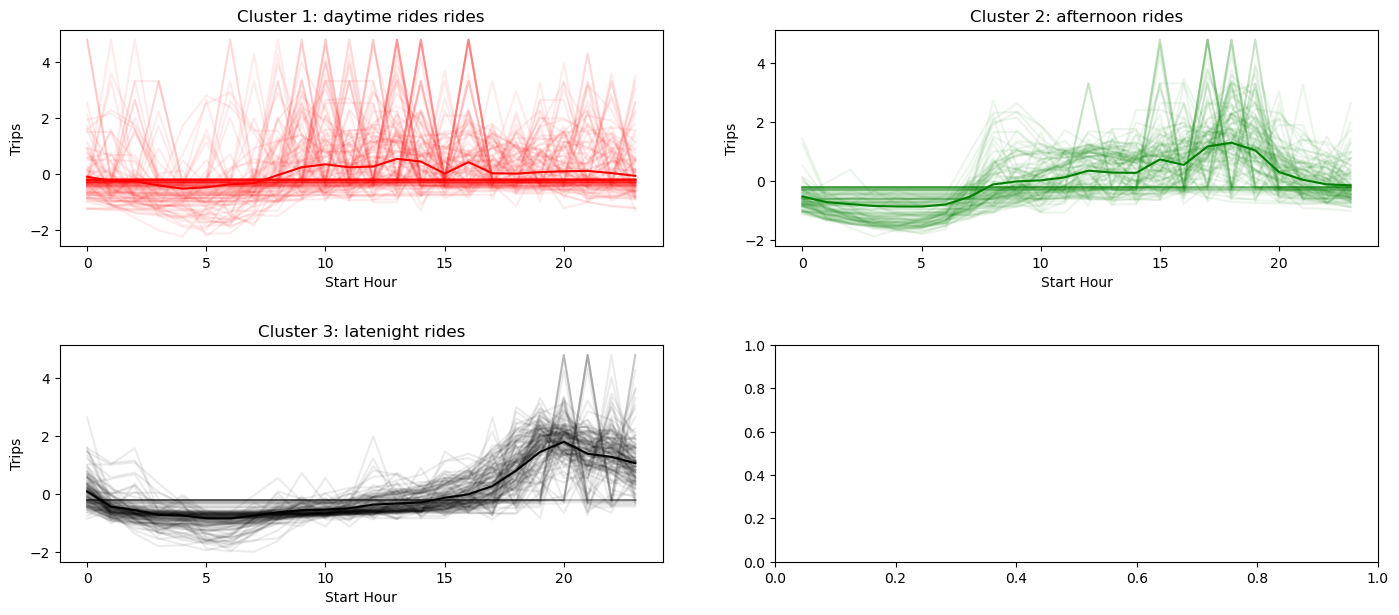

In [212]:
#plot the results gmm
fig, ax = plt.subplots(nrows = 2, ncols = 2,figsize=(15,7))
fig.tight_layout(pad = 5)

df_stations_one_gmm.plot(ax=ax[0,0],color='red', alpha=0.08)
df_stations_one_gmm["average"].plot(ax=ax[0,0],color='red', alpha=1)
ax[0,0].get_legend().remove(), ax[0,0].set_title('Cluster 1: daytime rides rides'), ax[0,0].set_ylabel('Trips'), ax[0,0].set_xlabel('Start Hour')

df_stations_two_gmm.plot(ax=ax[0,1],color='green', alpha=0.08)
df_stations_two_gmm["average"].plot(ax=ax[0,1],color='green', alpha=1)
ax[0,1].get_legend().remove(), ax[0,1].set_title('Cluster 2: afternoon rides'), ax[0,1].set_ylabel('Trips'), ax[0,1].set_xlabel('Start Hour')

df_stations_three_gmm.plot(ax=ax[1,0],color='black', alpha=0.08)
df_stations_three_gmm["average"].plot(ax=ax[1,0],color='black', alpha=1)
ax[1,0].get_legend().remove(), ax[1,0].set_title('Cluster 3: latenight rides'), ax[1,0].set_ylabel('Trips'), ax[1,0].set_xlabel('Start Hour')

#df_stations_four_gmm.plot(ax=ax[1,1],color='red', alpha=0.08)
#df_stations_four_gmm["average"].plot(ax=ax[1,1],color='red', alpha=1)
#ax[1,1].get_legend().remove(), ax[1,1].set_title('Cluster 4: work rides'), ax[1,1].set_ylabel('Trips'), ax[1,1].set_xlabel('Start Hour')

In [213]:
# spatial visualization preperation

# retrieve hexagon ID thorugh row index for each hexagon
df_clustering_end['agg_hex_id'] = df_clustering_end.index

# Add geometries (POLYGON) to dataframe by querying the h3 hexagon boundaries 
df_clustering_end['geometry'] = df_clustering_end['agg_hex_id'].apply(lambda id: Polygon(h3.h3_to_geo_boundary(id, geo_json=True)))

# create geodataframe for visualization  by extracting geometry of each hexagon and corresponding cluster assginments
df_viz_kmeans = geopandas.GeoDataFrame(df_clustering_end[['geometry', 'kmeans_cluster']], crs='EPSG:4326')
df_viz_gmm = geopandas.GeoDataFrame(df_clustering_end[['geometry', 'gmm_cluster']], crs='EPSG:4326')

In [215]:
df_viz_kmeans.explore(column = 'kmeans_cluster', cmap = ['green', 'red', 'black'])

In [217]:
df_viz_gmm.explore(column = 'gmm_cluster', cmap = ['green', 'red', 'black'])